# Data Set Creation Notebook

This notebook creates the composite data set used in the Geocomputation module. You are welcome to add additional data sets for the purposes of the final assessment in the module if you so wish.

In [1]:
# Needed on a Mac
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import requests
import pandas as pd
import geopandas as gpd

In [3]:
import os
def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

import zipfile
def extract_all(file_path):
    zip_ref = zipfile.ZipFile(file_path, 'r')
    zip_ref.extractall('.')
    zip_ref.close()

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))
    
def compress_all(srcdir, name):
    zipf = zipfile.ZipFile(name + '.zip', 'w', zipfile.ZIP_DEFLATED)
    zipdir(srcdir, zipf)
    zipf.close()

## London

Useful for filtering down the data sets that we've downloaded from OSOpen.

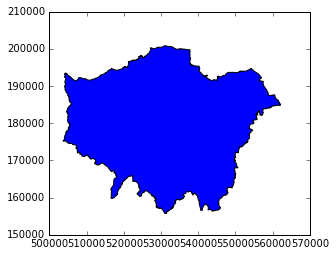

In [4]:
extract_all(os.path.join('Data','London.zip'))
ldn = gpd.read_file(os.path.join('London','London.shp'))
ldn.crs = {'init': u'epsg:27700'}
ldn.plot()

## Lower Super Output Area Data

Downloaded from the [London Data Store](https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london), with the Output Area shapefile extracted and re-compressed to save space on GitHub. 

In [5]:
# Extract Output Areas
extract_all(os.path.join('Data','LSOA.zip'))
lsoa = gpd.read_file(os.path.join('LSOA','LSOA_2011_London_gen_MHW.shp'))
lsoa.crs = {'init': u'epsg:27700'}

# Stash a copy of original geometry and the centroids
# since we'll need both again
#lsoa['outlines']  = lsoa.geometry
#lsoa['centroids'] = lsoa.geometry.centroid

In [6]:
# Notice the range of geographies to which we can now join:
# LSOA, MSOA, LA, and Region
# We've also got some very simple, basic measures such as
# population density, usual residents, and average household
# size.
lsoa.head(2)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,geometry
0,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,E12000007,London,1465,1465,0,112.9,876,1.7,"POLYGON ((532105.0919998939 182011.23, 532162...."
1,E01000002,City of London 001B,E02000001,City of London 001,E09000001,City of London,E12000007,London,1436,1436,0,62.9,830,1.7,"POLYGON ((532746.8130000263 181786.891000028, ..."


## OS Open Data Sets

You can download the following data sets from the [OS Open Download Page](https://www.ordnancesurvey.co.uk/opendatadownload/products.html). This step cannot easily be automated, sorry.

* OS Open Map - Local - ESRI SHAPE - TQ
* OS VectorMap District - ESRI Shape - TQ
* OS Open Greenspace - ESRI SHAPE - TQ

For each of these data sets, we have filtered out everything that is _not_ within the GLA boundary. This reduces file size significantly and can be done fairly quickly within QGIS.

### Open Greenspace

In [7]:
#extract_all(os.path.join('Data','opgrsp_essh_tq.zip'))

grsp = gpd.read_file(os.path.join('OS Open Greenspace (ESRI Shape File) TQ','data','TQ_GreenspaceSite.shp'))
grsp.crs = {'init': u'epsg:27700'}
print("Raw file has " + str(grsp.shape[0]) + " rows.")

grsp = grsp[grsp.function=='Public Park Or Garden']
grsp = gpd.sjoin(grsp, ldn, how="inner", op='within')

print("Filtered down to " + str(grsp.shape[0]) + " rows.")

ensure_dir(os.path.join('Greenspace','GLA Greenspace.shp'))
grsp.to_file(os.path.join('Greenspace','GLA Greenspace.shp'))

compress_all('Greenspace',os.path.join('Data','Greenspace'))

Raw file has 18023 rows.


/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:1880: RuntimeWarning: invalid value encountered in find_contains (vectorized)
  outputs = ufunc(*inputs)


Filtered down to 989 rows.


In [8]:
print("Starting buffer and dissolve...")
grspd = grsp.simplify(5).buffer(5).unary_union

print("Calculating intersection...")
lsoa_overlay = lsoa['geometry'].intersection(grspd)

print("Saving results to LSOA data frame...")
lsoa['greenspace'] = pd.Series(lsoa_overlay.geometry.area, index=lsoa.index)

Starting buffer and dissolve...
Calculating intersection...
Saving results to LSOA data frame...


## A- and M-class Roads

In [9]:
extract_all(os.path.join('Data','opmplc_essh_tq.zip'))

rds = gpd.read_file(os.path.join('OS OpenMap Local (ESRI Shape File) TQ','data','TQ_Road.shp'))
rds.crs = {'init': u'epsg:27700'}
print("Raw file has " + str(rds.shape[0]) + " rows.")

rds = rds[rds.CLASSIFICA.isin(['A Road','A Road, Collapsed Dual Carriageway','Motorway','Motorway, Collapsed Dual Carriageway'])]
rds = gpd.sjoin(rds, ldn, how="inner", op='within')

print("Filtered down to " + str(rds.shape[0]) + " rows.")

ensure_dir(os.path.join('Roads','Roads.shp'))
rds.to_file(os.path.join('Roads','Roads.shp'))

compress_all('Roads',os.path.join('Data','Roads'))

Raw file has 375482 rows.
Filtered down to 17988 rows.


In [10]:
print("Starting buffer and dissolve...")
impact = rds.simplify(25).buffer(250).unary_union

print("Calculating intersection...")
lsoa_overlay = lsoa['geometry'].intersection(impact)

print("Saving results to LSOA data frame...")
lsoa['hvy_roads'] = pd.Series(lsoa_overlay.geometry.area, index=lsoa.index)

Starting buffer and dissolve...
Calculating intersection...
Saving results to LSOA data frame...


In [11]:
ensure_dir(os.path.join('Physical','Physical.shp'))
lsoa.to_file(os.path.join('Physical','Physical.shp'))

## KS402EW - Tenure

In [12]:
tenure = pd.read_excel(os.path.join('Data','KS402EW - Tenure.xlsx'), header=8)
tenure['lsoacd'], tenure['lsoanm'] = tenure['2011 super output area - lower layer'].str.split(' : ').str
tenure.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
tenure.sample(2)

,Owned,Shared ownership (part owned and part rented),Social rented,Private rented,Living rent free,lsoacd
4393,290.0,1.0,23.0,245.0,8.0,E01003767
435,177.0,47.0,313.0,281.0,28.0,E01001979


In [13]:
lsoa = pd.merge(lsoa, tenure, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)
lsoa.sample(2)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,HHOLDS,AVHHOLDSZ,geometry,greenspace,hvy_roads,Owned,Shared ownership (part owned and part rented),Social rented,Private rented,Living rent free
3535,E01003616,Newham 012A,E02000725,Newham 012,E09000025,Newham,E12000007,London,1650,1650,...,658,2.5,"POLYGON ((538860.3610000833 185251.882999958, ...",0.0,58121.300583,153.0,12.0,226.0,257.0,10.0
4704,E01032788,Hammersmith and Fulham 023D,E02000394,Hammersmith and Fulham 023,E09000013,Hammersmith and Fulham,E12000007,London,1106,1099,...,496,2.2,"POLYGON ((526264.7460001282 176281.5390001138,...",0.0,33795.339915,170.0,3.0,177.0,142.0,4.0


## KS403EW - Rooms, bedrooms and central heating

In [14]:
rooms = pd.read_excel(os.path.join('Data','KS403EW - Rooms, bedrooms and central heating.xlsx'), header=8)
rooms['lsoacd'], rooms['lsoanm'] = rooms['2011 super output area - lower layer'].str.split(' : ').str
rooms.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
rooms.sample(2)
lsoa = pd.merge(lsoa, rooms, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,hvy_roads,Owned,Shared ownership (part owned and part rented),Social rented,Private rented,Living rent free,Occupancy rating (rooms) of -1 or less,Occupancy rating (bedrooms) of -1 or less,Average number of rooms per household,Average number of bedrooms per household
2197,E01002248,Havering 017C,E02000480,Havering 017,E09000016,Havering,E12000007,London,1397,1395,...,158819.317353,371.0,0.0,127.0,92.0,2.0,56.0,41.0,4.8,2.5
115,E01000119,Barnet 009C,E02000032,Barnet 009,E09000003,Barnet,E12000007,London,1680,1680,...,91906.985226,509.0,1.0,24.0,64.0,9.0,36.0,32.0,6.0,3.2


## KS201EW - Ethnic group

In [15]:
ethnicity = pd.read_excel(os.path.join('Data','KS201EW - Ethnic group.xlsx'), header=8)
ethnicity['lsoacd'], ethnicity['lsoanm'] = ethnicity['2011 super output area - lower layer'].str.split(' : ').str
ethnicity.drop(['lsoanm','2011 super output area - lower layer'], axis=1, inplace=True)
ethnicity.sample(2)
lsoa = pd.merge(lsoa, ethnicity, how='left', left_on='LSOA11CD', right_on='lsoacd')
lsoa.drop(['lsoacd'], axis=1, inplace=True)

,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,...,Living rent free,Occupancy rating (rooms) of -1 or less,Occupancy rating (bedrooms) of -1 or less,Average number of rooms per household,Average number of bedrooms per household,White,Mixed/multiple ethnic groups,Asian/Asian British,Black/African/Caribbean/Black British,Other ethnic group
1249,E01001269,Ealing 001A,E02000238,Ealing 001,E09000009,Ealing,E12000007,London,1983,1983,...,2.0,135.0,92.0,5.0,2.8,986.0,69.0,593.0,224.0,111.0
1388,E01001409,Enfield 005B,E02000281,Enfield 005,E09000010,Enfield,E12000007,London,1889,1881,...,10.0,205.0,94.0,4.2,2.2,1162.0,116.0,223.0,307.0,81.0


## Wrapping Up

Save the final output for use by students.

In [30]:
lsoa['Area'] = lsoa.geometry.area
lsoa.columns

Index([                                     u'LSOA11CD',
                                            u'LSOA11NM',
                                            u'MSOA11CD',
                                            u'MSOA11NM',
                                             u'LAD11CD',
                                             u'LAD11NM',
                                             u'RGN11CD',
                                             u'RGN11NM',
                                            u'USUALRES',
                                            u'HHOLDRES',
                                           u'COMESTRES',
                                              u'POPDEN',
                                              u'HHOLDS',
                                           u'AVHHOLDSZ',
                                            u'geometry',
                                          u'greenspace',
                                           u'hvy_roads',
                               

In [31]:
lsoadf = pd.DataFrame(lsoa.drop(['geometry'], axis=1))
lsoadf.to_csv(os.path.join('Data','LSOA Data.csv.gz'), compression='gzip')

In [16]:
ensure_dir(os.path.join('Final','LSOA Data.shp'))
lsoa.to_file(os.path.join('Final','LSOA Data.shp'))